# Decoding with Machine Learning

This notebook is going to load data, with the feature estimation steps already precomputed. Therefore, you cannot reproduce the results. We take this as a tutorial in how to use the decoding toolbox inside the py_neuromodulation pypeline. We also will run a typical exploratory data analysis - EDA, and will show how the user can take it's preferred models and cross-validation methods to run them here.

(We suggest you first follow example_BIDS.py and then come back here)

Again we start with importing the necessary packages:

Using baysian optimation, nested CV here!

notebook: ML with presaved data (run py_nm for upper data), read precomputed features, run decoding for individual channels, grid points, all channels combined. Visualize decoding results. Add typical EDA, e.g. boxplot of a single feature movement vs rest, time plot, correlation matrix of features,

In [12]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if os.path.basename(SCRIPT_DIR) == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import py_neuromodulation as nm
import xgboost
import matplotlib.pyplot as plt
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
)

sub = "008"
ses = "EcogLfpMedOff01"
task = "SelfpacedRotationR"
acq = "StimOff"
run = 1
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_acq-{acq}_run-{run}"

PATH_RUN = os.path.join(
    "/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data",
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = "/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data"

# Provide a path for the output data.
PATH_OUT = os.path.join("/home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data","derivatives")

As we showed in example_gridPointProjection, we can load saved features by using the ```nm_analysis.Feature_Reader``` class, by providing the appropriate paths.

In [14]:
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

We can investigate which channels, their rereferencing, type and status. Here we observe that the channel ```ANALOG_L_ROTA_CH``` was given as target for the movement decoding analysis that we are going to perform here. This channel corresponds to the recordings of an analog rotational handle.

Also recorded, but not used in this script are the accelerometers positioned on the patients arms. One could also use the accelerometers for movement prediction, but the rotational handle offers a much cleaner signal, therefore wielding better decoding performance.

In [15]:
feature_reader.nm_channels

,name,rereference,used,target,type,status,new_name
0,LFP_R_01_STN_BS,LFP_R_16_STN_BS,1,0,dbs,good,LFP_R_01_STN_BS-LFP_R_16_STN_BS
1,LFP_R_02_STN_BS,LFP_R_01_STN_BS,1,0,dbs,good,LFP_R_02_STN_BS-LFP_R_01_STN_BS
2,LFP_R_03_STN_BS,LFP_R_02_STN_BS,1,0,dbs,good,LFP_R_03_STN_BS-LFP_R_02_STN_BS
3,LFP_R_04_STN_BS,LFP_R_03_STN_BS,1,0,dbs,good,LFP_R_04_STN_BS-LFP_R_03_STN_BS
4,LFP_R_05_STN_BS,LFP_R_04_STN_BS,1,0,dbs,good,LFP_R_05_STN_BS-LFP_R_04_STN_BS
5,LFP_R_06_STN_BS,LFP_R_05_STN_BS,1,0,dbs,good,LFP_R_06_STN_BS-LFP_R_05_STN_BS
6,LFP_R_07_STN_BS,LFP_R_06_STN_BS,1,0,dbs,good,LFP_R_07_STN_BS-LFP_R_06_STN_BS
7,LFP_R_08_STN_BS,LFP_R_07_STN_BS,1,0,dbs,good,LFP_R_08_STN_BS-LFP_R_07_STN_BS
8,LFP_R_09_STN_BS,LFP_R_08_STN_BS,1,0,dbs,good,LFP_R_09_STN_BS-LFP_R_08_STN_BS
9,LFP_R_10_STN_BS,LFP_R_09_STN_BS,1,0,dbs,good,LFP_R_10_STN_BS-LFP_R_09_STN_BS


# Check ['ANALOG_R_ROTA_CH']

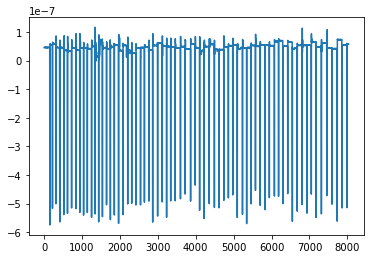

In [16]:
plt.plot(feature_reader.feature_arr['ANALOG_R_ROTA_CH'])

# Make it binary

In [17]:
# import numpy as np
# feature_reader.feature_arr['ANALOG_R_ROTA_CH'] = np.asarray(-1*feature_reader.feature_arr['ANALOG_R_ROTA_CH'] > 3e-7, dtype = int)

In [18]:
feature_reader.feature_arr['ANALOG_R_ROTA_CH'] = (-1*feature_reader.feature_arr['ANALOG_R_ROTA_CH'] > 3e-7) * 1

# Check if it worked

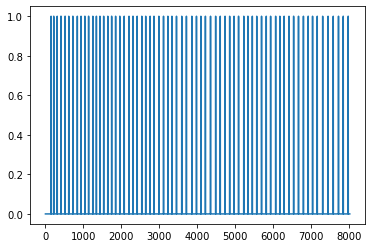

In [19]:
plt.plot(feature_reader.feature_arr['ANALOG_R_ROTA_CH'])

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/BIDS_data/derivatives/sub-008_ses-EcogLfpMedOff01_task-SelfpacedRotationR_acq-StimOff_run-1/MOV_aligned_features_ch_LFP_R_01_STN_BS-LFP_R_16_STN_BS_fft.png


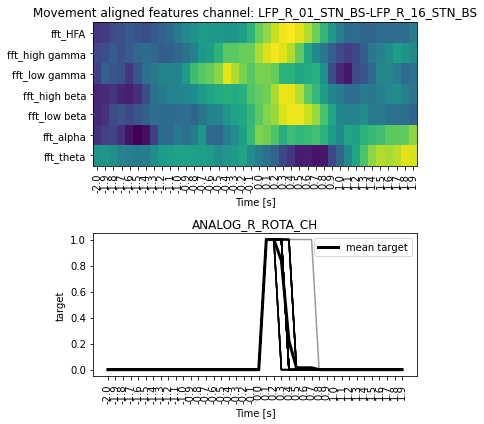

In [20]:
# plot for a single channel
ch_used = feature_reader.nm_channels.query(
    '(type=="dbs") and (used == 1)'
).iloc[0]["new_name"]

feature_reader.label = feature_reader.feature_arr['ANALOG_R_ROTA_CH']

feature_used = "fft"

feature_reader.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

In [23]:
feature_reader.feature_arr

,LFP_R_01_STN_BS-LFP_R_16_STN_BS_RawHjorth_Activity,LFP_R_01_STN_BS-LFP_R_16_STN_BS_RawHjorth_Mobility,LFP_R_01_STN_BS-LFP_R_16_STN_BS_RawHjorth_Complexity,LFP_R_02_STN_BS-LFP_R_01_STN_BS_RawHjorth_Activity,LFP_R_02_STN_BS-LFP_R_01_STN_BS_RawHjorth_Mobility,LFP_R_02_STN_BS-LFP_R_01_STN_BS_RawHjorth_Complexity,LFP_R_03_STN_BS-LFP_R_02_STN_BS_RawHjorth_Activity,LFP_R_03_STN_BS-LFP_R_02_STN_BS_RawHjorth_Mobility,LFP_R_03_STN_BS-LFP_R_02_STN_BS_RawHjorth_Complexity,LFP_R_04_STN_BS-LFP_R_03_STN_BS_RawHjorth_Activity,...,gridsubcortex_867_Sharpwave_Max_sharpness_range_5_30,gridsubcortex_877_Sharpwave_Max_sharpness_range_5_30,gridsubcortex_878_Sharpwave_Max_sharpness_range_5_30,gridsubcortex_879_Sharpwave_Max_sharpness_range_5_30,gridsubcortex_880_Sharpwave_Max_sharpness_range_5_30,gridsubcortex_891_Sharpwave_Max_sharpness_range_5_30,gridsubcortex_892_Sharpwave_Max_sharpness_range_5_30,gridsubcortex_1082_Sharpwave_Max_sharpness_range_5_30,time,ANALOG_R_ROTA_CH
0,6.243853e-11,0.490592,2.945583,4.952811e-10,0.181912,7.756087,3.987682e-10,0.199203,7.081970,3.286634e-11,...,0.000001,2.669359e-07,4.853114e-07,5.569224e-07,0.000001,7.167354e-07,0.000002,4.502685e-08,1000.0,0
1,7.697911e-01,0.563507,2.559992,9.659280e-01,0.184839,7.640447,9.712428e-01,0.204120,6.912907,9.946418e-01,...,-0.011978,-8.502027e-03,-7.681469e-03,-8.414974e-03,-0.009714,-9.981802e-03,-0.011429,-1.043588e-02,1100.0,0
2,5.712349e-01,0.661662,2.173313,8.439041e-01,0.200467,7.034132,8.412786e-01,0.222653,6.333869,9.281796e-01,...,-0.011677,-8.452175e-03,-7.761844e-03,-7.728374e-03,-0.006272,-7.731618e-03,-0.007111,-1.048151e-02,1200.0,0
3,6.021956e-01,0.637641,2.242487,6.483856e-01,0.231400,6.074349,6.740106e-01,0.249216,5.665647,9.956604e-01,...,-0.012171,-8.069832e-03,-7.668959e-03,-7.461054e-03,-0.004699,-7.099035e-03,-0.005091,-1.003290e-02,1300.0,0
4,5.890274e-01,0.637732,2.242674,4.376763e-01,0.283406,4.963442,5.017318e-01,0.291914,4.852791,1.141512e+00,...,-0.012013,-8.110583e-03,-7.656215e-03,-6.776523e-03,-0.004031,-5.858586e-03,-0.004275,-1.009636e-02,1400.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8026,2.008943e-02,0.441758,3.250659,7.826542e-02,0.489670,2.909587,8.222376e-02,0.497327,2.836560,5.620909e-02,...,-0.000972,-1.035100e-03,-1.368172e-03,-1.765224e-03,-0.001740,-1.866659e-03,-0.002040,-1.505070e-03,803600.0,0
8027,1.706379e-02,0.474746,3.028125,8.771035e-02,0.456612,3.135679,9.048830e-02,0.467275,3.022569,5.151124e-02,...,-0.000973,-6.419561e-04,-1.225823e-03,-2.014381e-03,-0.002425,-2.171128e-03,-0.002004,-6.936244e-04,803700.0,0
8028,1.341708e-02,0.535068,2.682320,9.298547e-02,0.446319,3.180663,9.959701e-02,0.438498,3.203054,4.761650e-02,...,-0.000974,-7.185126e-04,-1.260587e-03,-1.915214e-03,-0.001800,-1.973761e-03,-0.001280,-1.520770e-03,803800.0,0
8029,1.629758e-02,0.480477,2.996123,8.716475e-02,0.473432,2.992039,1.009496e-01,0.429296,3.275861,4.493193e-02,...,-0.000978,-9.996857e-04,-1.139155e-03,-1.996922e-03,-0.002732,-2.378659e-03,-0.002356,-1.494106e-03,803900.0,0


# Decoding

In [22]:
model = xgboost.XGBClassifier(use_label_encoder=False)

from sklearn import metrics, model_selection
feature_reader.decoder = nm_decode.Decoder(
    features=feature_reader.feature_arr,
    label=feature_reader.label,
    label_name=feature_reader.label_name,
    used_chs=feature_reader.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader.settings["sampling_rate_features_hz"],
)

performances = feature_reader.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per = feature_reader.get_dataframe_performances(performances)

nm_plots.plot_df_subjects(
    df_per, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance.png")
)

XGBoostError: [10:01:52] /home/conda/feedstock_root/build_artifacts/xgboost-split_1660208814268/work/src/data/data.cc:1163: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /home/lauraflyra/anaconda3/envs/pn_env/lib/libxgboost.so(+0xb3c3f) [0x7f8d74c19c3f]
  [bt] (1) /home/lauraflyra/anaconda3/envs/pn_env/lib/libxgboost.so(unsigned long xgboost::SparsePage::Push<xgboost::data::ArrayAdapterBatch>(xgboost::data::ArrayAdapterBatch const&, float, int)+0x583) [0x7f8d74ced453]
  [bt] (2) /home/lauraflyra/anaconda3/envs/pn_env/lib/libxgboost.so(xgboost::data::SimpleDMatrix::SimpleDMatrix<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int)+0x393) [0x7f8d74d291e3]
  [bt] (3) /home/lauraflyra/anaconda3/envs/pn_env/lib/libxgboost.so(xgboost::DMatrix* xgboost::DMatrix::Create<xgboost::data::ArrayAdapter>(xgboost::data::ArrayAdapter*, float, int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&)+0x38) [0x7f8d74cd73c8]
  [bt] (4) /home/lauraflyra/anaconda3/envs/pn_env/lib/libxgboost.so(XGDMatrixCreateFromDense+0x41e) [0x7f8d74c3867e]
  [bt] (5) /home/lauraflyra/anaconda3/envs/pn_env/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f8e1192ea4a]
  [bt] (6) /home/lauraflyra/anaconda3/envs/pn_env/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f8e1192dfea]
  [bt] (7) /home/lauraflyra/anaconda3/envs/pn_env/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12f70) [0x7f8e11946f70]
  [bt] (8) /home/lauraflyra/anaconda3/envs/pn_env/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12633) [0x7f8e11946633]



In [ ]:
df_per